# Importing Libraries

In [1]:
!pip install jovian --upgrade --quiet
import jovian
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import fastai
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as tt
import torch.nn.functional as F
from torchvision import datasets, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, random_split, DataLoader
%matplotlib inline


<IPython.core.display.Javascript object>

In [2]:
project_name='malaria-cnn-basic'

# Importing Data and Creating Relevant Datasets and Dataloaders

In [3]:
base_tfms = tt.Compose([tt.Resize((109,109)),
                        tt.ToTensor()])

In [4]:
img_dir ='../input/cell-images-for-detecting-malaria/cell_images'
dataset = datasets.ImageFolder(img_dir,transform = base_tfms)

In [5]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [6]:
type(dataset)

torchvision.datasets.folder.ImageFolder

In [7]:
random_seed = 87
torch.manual_seed(random_seed);

In [8]:
val_pct = 0.20
test_pct = 0.10
val_size = int(val_pct * len(dataset))
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(38582, 11023, 5511)

In [9]:
batch_size = 36
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

# Data Augmentation

In [10]:
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.Resize((109,109)),
                         tt.ToTensor(),
                         tt.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225],inplace=True)])

test_tfms = tt.Compose([tt.Resize((109,109)),
                        tt.ToTensor(),
                        tt.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [11]:
train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = test_tfms
test_ds.dataset.transform = test_tfms

# Displaying a batch

In [12]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print(target)

2


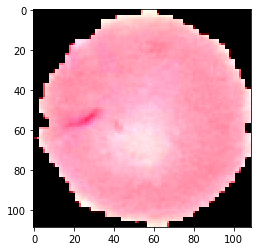

In [13]:
show_sample(*test_ds[0], invert=False)

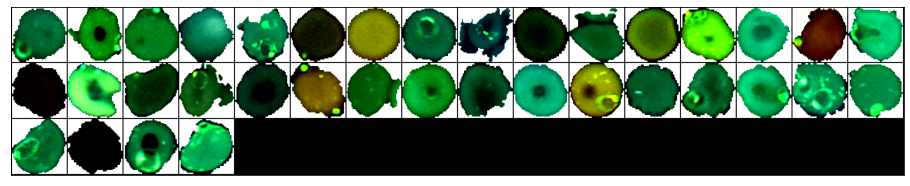

In [14]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break
        
show_batch(train_dl)

In [ ]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/moaaz645/malaria-cnn-basic


<IPython.core.display.Javascript object>

# Moving The Dataloaders to GPU if Availible

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
len(train_dl)

# Defining The Model

In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred)).float()

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [ ]:
class BinaryImageClassificationBase(FocalLoss):
    def training_step(self, batch):
        images, targets = batch
        targets = targets.view(-1,1)
        images = images.to(torch.float32)
        targets = targets.to(torch.float32)
        out = self(images)
        out = out.to(torch.float32)
        loss = F.binary_cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        targets = targets.to(torch.float32)
        targets = targets.view(-1,1)
        images = images.to(torch.float32)
        out = self(images)
        out = out.to(torch.float32)
        loss = F.binary_cross_entropy(out, targets)  # Calculate loss
        score = binary_acc(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".fo)

In [ ]:
class MalariaCnnModel(BinaryImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 9, kernel_size=4, padding=2),
            nn.RReLU(0.1, 0.5),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(9, 18, kernel_size=4, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(18, 36, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),
            nn.Conv2d(36, 100, kernel_size=3, stride=1, padding=1),
            nn.RReLU(0.1, 0.35),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(100, 200, kernel_size=2, stride=1, padding=1),
            nn.Hardshrink(lambd=0.5),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(200, 200, kernel_size=2, stride=1, padding=1),
            nn.GELU(),
            nn.AvgPool2d(2, 2),

            nn.Conv2d(200, 150, kernel_size=1, stride=1, padding=1),
            nn.RReLU(0.1, 0.2),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(150, 100, kernel_size=1, stride=2, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),

            nn.Flatten(),
            nn.Linear(100, 50),
            torch.nn.CELU(),
            nn.Linear(50, 25),
            nn.ReLU(),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [ ]:
model = MalariaCnnModel()
model

In [ ]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(MalariaCnnModel(), device)
evaluate(model, val_dl)

# Training


In [ ]:
num_epochs = 5
opt_func = torch.optim.AdamW
lr = 0.003

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)